In [1]:
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

from imblearn.datasets import make_imbalance


In [2]:
import numpy as np
import tensorflow as tf

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [10]:
# Generate the dataset
multiplier = 1.0
desiredtotal = 100000
nsamp = int(np.round(2*desiredtotal/(1+multiplier)))
Xfull, yfull = make_moons(n_samples=nsamp, shuffle=True, noise=0.05, random_state=10)

def ratio_func(y, multiplier, minority_class):
    target_stats = Counter(y)
    return {minority_class: int(multiplier * target_stats[minority_class])}



Xdat, ydat = make_imbalance(Xfull, yfull, sampling_strategy=ratio_func,
                            **{"multiplier": multiplier,
                               "minority_class": 1})


In [11]:
print(np.array([np.sum(ydat==1), np.sum(ydat==0)]))

[50000 50000]


In [12]:
alldat = np.hstack([Xdat, np.expand_dims(ydat, axis=1)])
np.random.shuffle(alldat)
print(alldat.shape)

(100000, 3)


In [13]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [14]:
X = tf.placeholder(tf.float32, shape=[None, 3])

Dnn = 20

D_W1 = tf.Variable(xavier_init([3, Dnn]))
D_b1 = tf.Variable(tf.zeros(shape=[Dnn]))

D_W2 = tf.Variable(xavier_init([Dnn, Dnn]))
D_b2 = tf.Variable(tf.zeros(shape=[Dnn]))

D_W3 = tf.Variable(xavier_init([Dnn, 1]))
D_b3 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

In [15]:
Z_dim = 10
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

Gnn = 20

G_W1 = tf.Variable(xavier_init([Z_dim, Gnn]))
G_b1 = tf.Variable(tf.zeros(shape=[Gnn]))

G_W2 = tf.Variable(xavier_init([Gnn, Gnn]))
G_b2 = tf.Variable(tf.zeros(shape=[Gnn]))

G_W3 = tf.Variable(xavier_init([Gnn, 3]))
G_b3 = tf.Variable(tf.zeros(shape=[3]))

theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

In [19]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)
    G_h3 = tf.matmul(G_h2, G_W3) + G_b3
    return G_h3


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_h2 = tf.nn.relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_logit = tf.matmul(D_h2, D_W3) + D_b3
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit


In [20]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)


In [23]:
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(G_loss, var_list=theta_G)




In [24]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

mb_size = 100
adr = alldat.shape[0]

i = 0

for it in range(1000000):
    eit = it % (adr // mb_size)
    si = eit * mb_size
    ei = (eit+1) * mb_size
    X_mb = alldat[si:ei, :]

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(mb_size, Z_dim)})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()
    
    if it % 1000 == 0:
        test = sess.run(G_sample, feed_dict={Z: sample_Z(100000, Z_dim)})
        testc = np.array(np.round(test[:,2]),dtype='int32')
        fig = plt.figure(figsize=(4, 4))
        plt.scatter(test[testc == 0, 0], test[testc == 0, 1], label="Class #0", alpha=0.5, s=0.01)
        plt.scatter(test[testc == 1, 0], test[testc == 1, 1], label="Class #1", alpha=0.5, s=0.01)
        plt.savefig('out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

        


Iter: 0
D loss: 1.065
G_loss: 0.9743

Iter: 1000
D loss: 1.183
G_loss: 0.8865

Iter: 2000
D loss: 1.42
G_loss: 0.6925

Iter: 3000
D loss: 1.307
G_loss: 0.8321

Iter: 4000
D loss: 1.286
G_loss: 0.758

Iter: 5000
D loss: 1.281
G_loss: 0.7776

Iter: 6000
D loss: 1.277
G_loss: 0.7786

Iter: 7000
D loss: 1.256
G_loss: 0.7982

Iter: 8000
D loss: 1.22
G_loss: 0.8051

Iter: 9000
D loss: 1.204
G_loss: 0.8606

Iter: 10000
D loss: 1.164
G_loss: 0.868

Iter: 11000
D loss: 1.179
G_loss: 0.8808

Iter: 12000
D loss: 1.127
G_loss: 0.8957

Iter: 13000
D loss: 1.152
G_loss: 0.8322

Iter: 14000
D loss: 1.147
G_loss: 1.016

Iter: 15000
D loss: 1.157
G_loss: 0.9423

Iter: 16000
D loss: 1.178
G_loss: 1.01

Iter: 17000
D loss: 1.214
G_loss: 1.005

Iter: 18000
D loss: 1.183
G_loss: 0.9273

Iter: 19000
D loss: 1.267
G_loss: 0.9568

Iter: 20000
D loss: 1.257
G_loss: 0.9518

Iter: 21000
D loss: 1.247
G_loss: 0.832

Iter: 22000
D loss: 1.266
G_loss: 0.832

Iter: 23000
D loss: 1.276
G_loss: 0.8861

Iter: 24000
D l

Iter: 195000
D loss: 1.387
G_loss: 0.7199

Iter: 196000
D loss: 1.381
G_loss: 0.6883

Iter: 197000
D loss: 1.378
G_loss: 0.7475

Iter: 198000
D loss: 1.39
G_loss: 0.7455

Iter: 199000
D loss: 1.394
G_loss: 0.7059

Iter: 200000
D loss: 1.392
G_loss: 0.7418

Iter: 201000
D loss: 1.391
G_loss: 0.7298

Iter: 202000
D loss: 1.39
G_loss: 0.697

Iter: 203000
D loss: 1.386
G_loss: 0.7083

Iter: 204000
D loss: 1.387
G_loss: 0.6882

Iter: 205000
D loss: 1.396
G_loss: 0.6837

Iter: 206000
D loss: 1.386
G_loss: 0.6686

Iter: 207000
D loss: 1.379
G_loss: 0.6794

Iter: 208000
D loss: 1.39
G_loss: 0.7765

Iter: 209000
D loss: 1.391
G_loss: 0.7322

Iter: 210000
D loss: 1.395
G_loss: 0.6812

Iter: 211000
D loss: 1.388
G_loss: 0.7025

Iter: 212000
D loss: 1.392
G_loss: 0.7101

Iter: 213000
D loss: 1.388
G_loss: 0.6839

Iter: 214000
D loss: 1.387
G_loss: 0.7019

Iter: 215000
D loss: 1.387
G_loss: 0.6878

Iter: 216000
D loss: 1.383
G_loss: 0.682

Iter: 217000
D loss: 1.383
G_loss: 0.7122

Iter: 218000
D l

Iter: 387000
D loss: 1.389
G_loss: 0.7294

Iter: 388000
D loss: 1.389
G_loss: 0.686

Iter: 389000
D loss: 1.381
G_loss: 0.6868

Iter: 390000
D loss: 1.38
G_loss: 0.6844

Iter: 391000
D loss: 1.368
G_loss: 0.689

Iter: 392000
D loss: 1.382
G_loss: 0.7113

Iter: 393000
D loss: 1.377
G_loss: 0.6993

Iter: 394000
D loss: 1.382
G_loss: 0.6783

Iter: 395000
D loss: 1.389
G_loss: 0.7175

Iter: 396000
D loss: 1.369
G_loss: 0.749

Iter: 397000
D loss: 1.379
G_loss: 0.6856

Iter: 398000
D loss: 1.391
G_loss: 0.6741

Iter: 399000
D loss: 1.362
G_loss: 0.7229

Iter: 400000
D loss: 1.382
G_loss: 0.7038

Iter: 401000
D loss: 1.388
G_loss: 0.7155

Iter: 402000
D loss: 1.386
G_loss: 0.6781

Iter: 403000
D loss: 1.385
G_loss: 0.6894

Iter: 404000
D loss: 1.383
G_loss: 0.6958

Iter: 405000
D loss: 1.376
G_loss: 0.7533

Iter: 406000
D loss: 1.383
G_loss: 0.7101

Iter: 407000
D loss: 1.373
G_loss: 0.7731

Iter: 408000
D loss: 1.38
G_loss: 0.6679

Iter: 409000
D loss: 1.383
G_loss: 0.6727

Iter: 410000
D l

Iter: 579000
D loss: 1.358
G_loss: 0.7281

Iter: 580000
D loss: 1.363
G_loss: 0.7325

Iter: 581000
D loss: 1.378
G_loss: 0.6777

Iter: 582000
D loss: 1.381
G_loss: 0.6888

Iter: 583000
D loss: 1.371
G_loss: 0.7448

Iter: 584000
D loss: 1.381
G_loss: 0.7445

Iter: 585000
D loss: 1.343
G_loss: 0.7195

Iter: 586000
D loss: 1.377
G_loss: 0.7472

Iter: 587000
D loss: 1.379
G_loss: 0.7087

Iter: 588000
D loss: 1.372
G_loss: 0.6916

Iter: 589000
D loss: 1.368
G_loss: 0.8142

Iter: 590000
D loss: 1.388
G_loss: 0.6855

Iter: 591000
D loss: 1.371
G_loss: 0.6927

Iter: 592000
D loss: 1.301
G_loss: 0.7656

Iter: 593000
D loss: 1.383
G_loss: 0.6824

Iter: 594000
D loss: 1.293
G_loss: 0.8189

Iter: 595000
D loss: 1.363
G_loss: 0.7112

Iter: 596000
D loss: 1.382
G_loss: 0.6825

Iter: 597000
D loss: 1.374
G_loss: 0.6888

Iter: 598000
D loss: 1.369
G_loss: 0.725

Iter: 599000
D loss: 1.381
G_loss: 0.6866

Iter: 600000
D loss: 1.343
G_loss: 0.7107

Iter: 601000
D loss: 1.363
G_loss: 0.7363

Iter: 602000

Iter: 771000
D loss: 1.313
G_loss: 0.7235

Iter: 772000
D loss: 1.325
G_loss: 0.7393

Iter: 773000
D loss: 1.223
G_loss: 0.9

Iter: 774000
D loss: 1.348
G_loss: 0.7017

Iter: 775000
D loss: 1.299
G_loss: 0.8041

Iter: 776000
D loss: 1.305
G_loss: 0.7504

Iter: 777000
D loss: 1.289
G_loss: 0.748

Iter: 778000
D loss: 1.357
G_loss: 0.7276

Iter: 779000
D loss: 1.316
G_loss: 0.8934

Iter: 780000
D loss: 1.239
G_loss: 0.8067

Iter: 781000
D loss: 1.297
G_loss: 0.7276

Iter: 782000
D loss: 1.27
G_loss: 0.7986

Iter: 783000
D loss: 1.317
G_loss: 0.7564

Iter: 784000
D loss: 1.27
G_loss: 0.7781

Iter: 785000
D loss: 1.362
G_loss: 0.6629

Iter: 786000
D loss: 1.337
G_loss: 0.6969

Iter: 787000
D loss: 1.255
G_loss: 0.8988

Iter: 788000
D loss: 1.365
G_loss: 0.6721

Iter: 789000
D loss: 1.156
G_loss: 1.089

Iter: 790000
D loss: 1.327
G_loss: 0.7064

Iter: 791000
D loss: 1.361
G_loss: 0.6717

Iter: 792000
D loss: 1.35
G_loss: 0.6746

Iter: 793000
D loss: 1.345
G_loss: 0.6839

Iter: 794000
D loss

Iter: 964000
D loss: 1.299
G_loss: 0.6795

Iter: 965000
D loss: 1.126
G_loss: 0.859

Iter: 966000
D loss: 1.095
G_loss: 1.066

Iter: 967000
D loss: 1.28
G_loss: 0.7697

Iter: 968000
D loss: 1.303
G_loss: 0.7344

Iter: 969000
D loss: 1.253
G_loss: 0.7288

Iter: 970000
D loss: 1.327
G_loss: 0.6952

Iter: 971000
D loss: 1.297
G_loss: 0.8141

Iter: 972000
D loss: 1.235
G_loss: 0.9471

Iter: 973000
D loss: 1.243
G_loss: 0.7444

Iter: 974000
D loss: 1.305
G_loss: 0.7536

Iter: 975000
D loss: 1.102
G_loss: 1.414

Iter: 976000
D loss: 1.123
G_loss: 0.861

Iter: 977000
D loss: 1.27
G_loss: 0.7464

Iter: 978000
D loss: 1.211
G_loss: 0.8452

Iter: 979000
D loss: 1.272
G_loss: 0.6903

Iter: 980000
D loss: 1.229
G_loss: 0.8786

Iter: 981000
D loss: 1.261
G_loss: 0.7836

Iter: 982000
D loss: 1.18
G_loss: 0.9343

Iter: 983000
D loss: 0.9882
G_loss: 1.209

Iter: 984000
D loss: 1.295
G_loss: 0.8281

Iter: 985000
D loss: 1.229
G_loss: 0.6954

Iter: 986000
D loss: 1.286
G_loss: 0.6985

Iter: 987000
D los

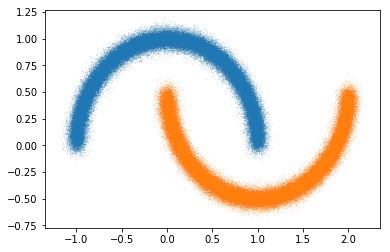

In [89]:
plt.scatter(Xfull[yfull == 0, 0], Xfull[yfull == 0, 1], label="Class #0", alpha=0.5, s=0.01)
plt.scatter(Xfull[yfull == 1, 0], Xfull[yfull == 1, 1], label="Class #1", alpha=0.5, s=0.01)
plt.show()
# ax.scatter(X_[y_ == 1, 0], X_[y_ == 1, 1], label="Class #1", alpha=0.5)

In [46]:
test = sess.run(G_sample, feed_dict={Z: sample_Z(900000, Z_dim)})

In [47]:
testc = np.array(np.round(test[:,2]),dtype='int32')
print(sum(testc==0))
print(sum(testc==1))

816822
83178


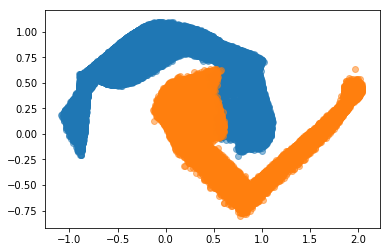

In [48]:
plt.scatter(test[testc == 0, 0], test[testc == 0, 1], label="Class #0", alpha=0.5)
plt.scatter(test[testc == 1, 0], test[testc == 1, 1], label="Class #1", alpha=0.5)
plt.show()


In [49]:
test[:,2] = testc

In [50]:
newdat = np.vstack([alldat, test[testc==1,:]])

In [51]:
newdat.shape

(183177, 3)

In [52]:
print(np.array([np.sum(newdat[:,2]==1), np.sum(newdat[:,2]==0)]))

[92268 90909]


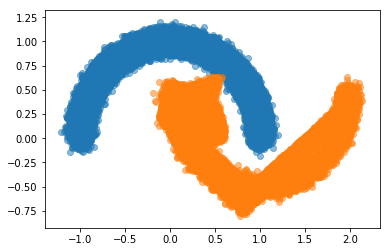

In [53]:
plt.scatter(newdat[newdat[:,2] == 0, 0], newdat[newdat[:,2] == 0, 1], label="Class #0", alpha=0.5)
plt.scatter(newdat[newdat[:,2] == 1, 0], newdat[newdat[:,2] == 1, 1], label="Class #1", alpha=0.5)
plt.show()
